In [1]:
#Data source:
#https://www.kaggle.com/zynicide/wine-reviews

In [5]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')

<h1>Loading and Cleaning</h1>

In [7]:
data = pd.read_csv('../input/wine-reviews/winemag-data_first150k.csv')
#data = data.sample(frac = 0.2) #optional sample for faster iterations

In [8]:
#Dropping rows with missing price and price > 1000
missing_price = data[data['price'].isna()].shape[0] / data.shape[0]
data = data[(data['price']>0) & (data['price']<1000)]
print("Dropped {:.1%} of rows".format(missing_price))

Dropped 9.1% of rows


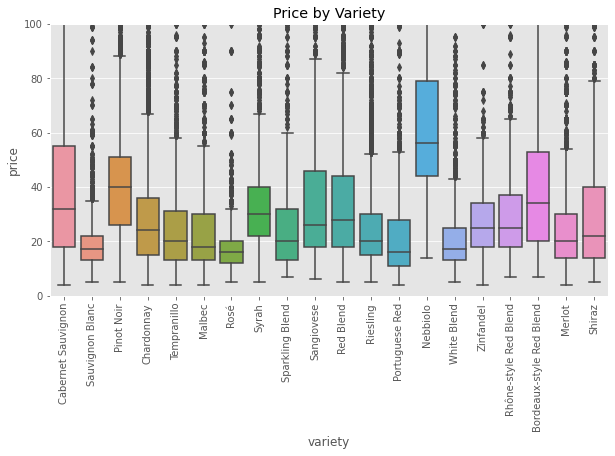

In [9]:
#Plotting price by variety
top_varieties = data['variety'].value_counts().head(20).index
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(
    x = 'variety',
    y = 'price',
    data = data[data['variety'].isin(top_varieties)]
)
plt.ylim(0,100)
plt.xticks(rotation=90) 
plt.title('Price by Variety')
plt.show()

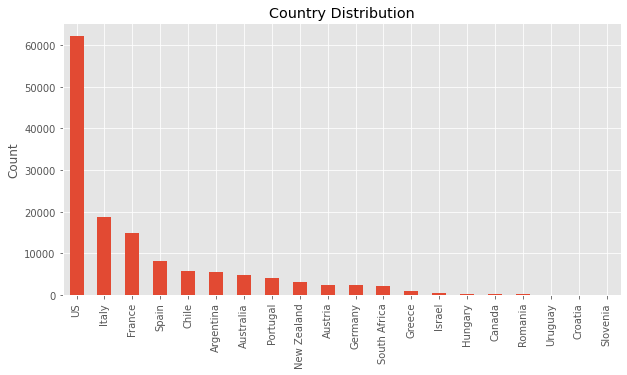

In [10]:
#Plotting country distribution
fig, ax = plt.subplots(figsize=(10,5))
data['country'].value_counts().head(20).plot.bar()
plt.title('Country Distribution')
plt.ylabel('Count')
plt.show()

In [11]:
#Transforming continuous price to multiclass variable
labels = ['Low range','Mid range','High range']
data['price_range'] = (pd.cut(data['price'], [0,40,100,1000], labels=labels)).astype(str)

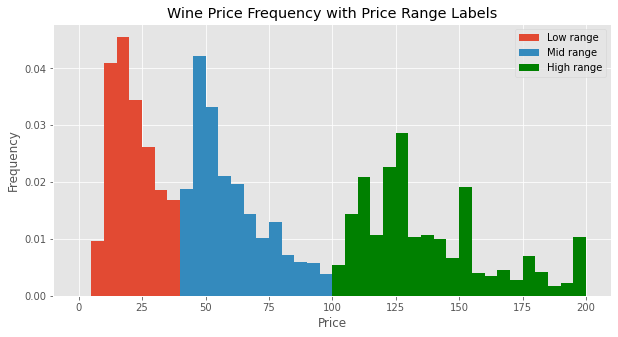

In [12]:
#Plotting target variable
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(data[data['price_range'] == 'Low range']['price'], range = (0,200), bins = 40, density=True)
plt.hist(data[data['price_range'] == 'Mid range']['price'], range = (0,200), bins = 40, density=True)
plt.hist(data[data['price_range'] == 'High range']['price'], range = (0,200), bins = 40, density=True, color = 'green')
plt.title('Wine Price Frequency with Price Range Labels')
plt.legend(labels)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [13]:
data.describe(include='object')

,country,description,designation,province,region_1,region_2,variety,winery,price_range
count,137219,137224,94919,137219,114383,60703,137224,137224,137224
unique,46,89099,28345,446,1197,18,619,13852,3
top,US,"Powerful in Zinny character, this blend of Dry...",Reserve,California,Napa Valley,Central Coast,Chardonnay,Williams Selyem,Low range
freq,62138,6,2704,44355,6191,12986,13771,371,105918


<h1>Prediction</h1>

<h2>Baseline model before text processing</h2>

In [14]:
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, precision_score, recall_score

#Numeric preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler()),
])

#Transforming numeric features
num_features = pd.DataFrame(numeric_transformer.fit_transform(data[['points']]), index = data.index)

#Target, classifier and scoring metrics
target = data['price_range']
clf = LogisticRegression()
scoring = {'accuracy': 'accuracy', 'precision':'precision_macro', 'recall':'recall_macro'}

#Cross validation 5-fold
cv_score = cross_validate(clf, num_features, target, cv=5, scoring = scoring)
print("Baseline model - Accuracy: {:.2f}".format(np.mean(cv_score['test_accuracy'])))
print("Baseline model - Precision: {:.2f}".format(np.mean(cv_score['test_precision'])))
print("Baseline model - Recall: {:.2f}".format(np.mean(cv_score['test_recall'])))

Baseline model - Accuracy: 0.81
Baseline model - Precision: 0.71
Baseline model - Recall: 0.45


<h2>Text processing</h2>

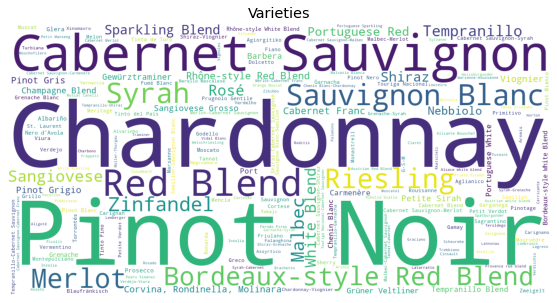

In [17]:
#Varieties
fig, ax = plt.subplots(figsize=(10,5))
wordcloud = WordCloud(width=1200, height=600, background_color ='white', 
                      stopwords = 'english', 
                      min_font_size = 5)
wordcloud.generate_from_frequencies(data['variety'].value_counts())
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Varieties")
plt.show()

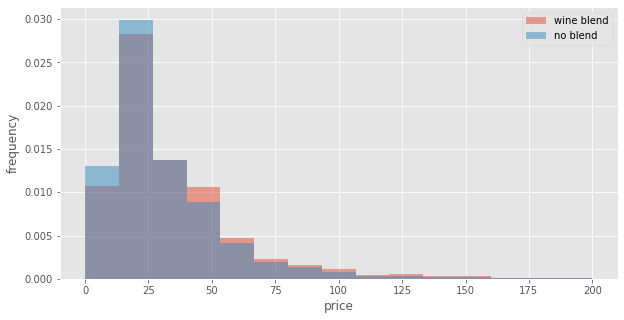

In [12]:
#Extracting wine blend from Variety
data['blend'] = data['variety'].str.lower().str.contains('blend')

#Checking relevance
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(data[data['blend']]['price'], range = (0,200), bins = 15, alpha=0.5, density=True)
plt.hist(data[~data['blend']]['price'], range = (0,200), bins = 15, alpha=0.5, density=True)
plt.legend(['wine blend','no blend'])
plt.xlabel('price')
plt.ylabel('frequency')
plt.show()

In [13]:
#Getting aroma vocabulary (based on https://winefolly.com/tips/wine-aroma-wheel-100-flavors/) 
aromas = pd.read_csv('../Desktop/WineAromas.csv')
aroma_list = list(aromas['Aroma'].str.lower().values)

#Extracting the most named aroma from the description
cvec = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), vocabulary = aroma_list)
cvec_fit = cvec.fit_transform(data['description'])
aroma_features = pd.DataFrame(cvec_fit.todense(), columns= cvec.get_feature_names(), index=data.index)
data['predominant_aroma'] = aroma_features.idxmax(axis=1)

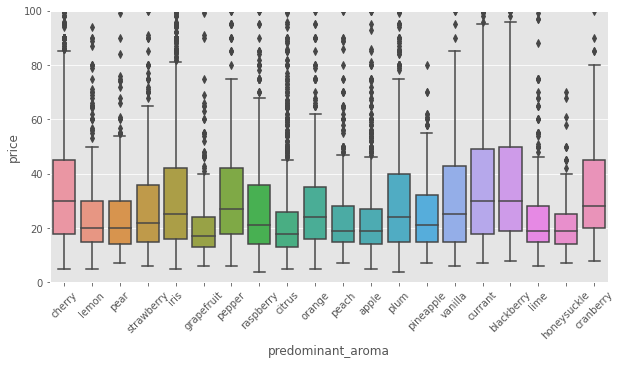

In [14]:
#Plotting price by aroma
top_aromas = data['predominant_aroma'].value_counts().head(20).index
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(
    x = 'predominant_aroma',
    y = 'price',
    data = data[data['predominant_aroma'].isin(top_aromas)]
)
plt.ylim(0,100)
plt.xticks(rotation=45) 
plt.show()

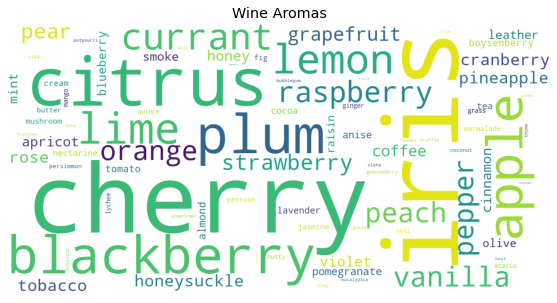

In [15]:
#Plotting most frequent aromas
fig, ax = plt.subplots(figsize=(10,5))
wordcloud = WordCloud(width=1200, height=600, background_color ='white', 
                      stopwords = 'english', 
                      min_font_size = 5)
wordcloud.generate_from_frequencies(data['predominant_aroma'].value_counts())
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wine Aromas")
plt.show()

<h2>Model with numerical, categorical and text features combined</h2>

In [16]:
#Creating seperate transformers for numerical, categorical and text features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler()),
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

text_transformer = Pipeline(steps=[
    ('vect', CountVectorizer()), #vocabulary=aroma_list --> Using a predefined vocabulary of aromas performed worse
    ('tdidf', TfidfTransformer())
])

#Transforming features with each transformer
num_features = numeric_transformer.fit_transform(data[['points']])
cat_features = cat_transformer.fit_transform(data[['country','region_1','region_2','variety','province','winery']])
text_features = text_transformer.fit_transform(data['description'])


#Merging features together
features = pd.concat([
    pd.DataFrame(num_features, index=data.index),
    pd.DataFrame(cat_features.todense(), index=data.index), 
    #pd.DataFrame(text_features.todense(), index=data.index), 
], axis = 1)

#Target, classifier and scoring metrics
target = data['price_range']
#MultinomialNB() performed better with the tf-idf transformed text description but LogisticRegression was overall better 
clf = LogisticRegression(C=5, max_iter=500) 
scoring = {'accuracy':'accuracy', 'precision':'precision_macro', 'recall':'recall_macro'}

#Grid search for fine tuning
#param_grid = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}; GridSearchCV(clf, param_grid)
#grid_clf = GridSearchCV(clf, param_grid)
#grid_clf.fit(features, target)
#print(grid_clf.best_estimator_)
#print(grid_clf.best_score_)

#Cross validation 5-fold
cv_score = cross_validate(clf, features, target, cv=5, scoring = scoring)
print("Advanced model - Accuracy: {:.2f}".format(np.mean(cv_score['test_accuracy'])))
print("Advanced model - Precision: {:.2f}".format(np.mean(cv_score['test_precision'])))
print("Advanced model - Recall: {:.2f}".format(np.mean(cv_score['test_recall'])))

Advanced model - Accuracy: 0.87
Advanced model - Precision: 0.76
Advanced model - Recall: 0.68


<h2>Results</h2>
<p>
Baseline model - Accuracy: 0.81 <br>
Baseline model - Precision: 0.67 <br>
Baseline model - Recall: 0.45 <br>
<br>
Advanced model - Accuracy: 0.87 <br>
Advanced model - Precision: 0.76 <br>
Advanced model - Recall: 0.68 <br>
<br>
This is a clear improvement in all metrics.
</p>